In [1]:
# Imports
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline

In [2]:
# === 0. Load Datasets ===
# 0.1 HPC dataset (Windows Behavior)
hpc_path = 'MalMem2022.csv'
hpc_df = pd.read_csv(hpc_path)
print("HPC columns:", hpc_df.columns.tolist())

# 0.2 Android datasets: emulator & real, benign vs malware
paths = {
    'emu_legit': 'emu_legitimate_v1.csv',
    'emu_mal':   'emu_malware_v1.csv',
    'real_legit': 'real_legitimate_v1.csv',
    'real_mal':  'real_malware_v1.csv'
}
android_parts = []
for name, p in paths.items():
    df = pd.read_csv(p)
    label = 0 if 'legit' in name else 1
    df['label'] = label
    android_parts.append(df)
android_df = pd.concat(android_parts, ignore_index=True)
print("Android columns:", android_df.columns.tolist())

HPC columns: ['pslist.nproc', 'pslist.nppid', 'pslist.avg_threads', 'pslist.nprocs64bit', 'pslist.avg_handlers', 'dlllist.ndlls', 'dlllist.avg_dlls_per_proc', 'handles.nhandles', 'handles.avg_handles_per_proc', 'handles.nport', 'handles.nfile', 'handles.nevent', 'handles.ndesktop', 'handles.nkey', 'handles.nthread', 'handles.ndirectory', 'handles.nsemaphore', 'handles.ntimer', 'handles.nsection', 'handles.nmutant', 'ldrmodules.not_in_load', 'ldrmodules.not_in_init', 'ldrmodules.not_in_mem', 'ldrmodules.not_in_load_avg', 'ldrmodules.not_in_init_avg', 'ldrmodules.not_in_mem_avg', 'malfind.ninjections', 'malfind.commitCharge', 'malfind.protection', 'malfind.uniqueInjections', 'psxview.not_in_pslist', 'psxview.not_in_eprocess_pool', 'psxview.not_in_ethread_pool', 'psxview.not_in_pspcid_list', 'psxview.not_in_csrss_handles', 'psxview.not_in_session', 'psxview.not_in_deskthrd', 'psxview.not_in_pslist_false_avg', 'psxview.not_in_eprocess_pool_false_avg', 'psxview.not_in_ethread_pool_false_avg

Using 'Class' as label for HPC data
HPC Epoch 1/10, Loss=0.0219
HPC Epoch 1/10, Loss=0.0219
HPC Epoch 2/10, Loss=0.0043
HPC Epoch 2/10, Loss=0.0043
HPC Epoch 3/10, Loss=0.0057
HPC Epoch 3/10, Loss=0.0057
HPC Epoch 4/10, Loss=0.0037
HPC Epoch 4/10, Loss=0.0037
HPC Epoch 5/10, Loss=0.0015
HPC Epoch 5/10, Loss=0.0015
HPC Epoch 6/10, Loss=0.0012
HPC Epoch 6/10, Loss=0.0012
HPC Epoch 7/10, Loss=0.0010
HPC Epoch 7/10, Loss=0.0010
HPC Epoch 8/10, Loss=0.0023
HPC Epoch 8/10, Loss=0.0023
HPC Epoch 9/10, Loss=0.0008
HPC Epoch 9/10, Loss=0.0008
HPC Epoch 10/10, Loss=0.0006
HPC Epoch 10/10, Loss=0.0006
HPC Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5860
           1       1.00      1.00      1.00      5860

    accuracy                           1.00     11720
   macro avg       1.00      1.00      1.00     11720
weighted avg       1.00      1.00      1.00     11720

HPC Test Accuracy: 0.9998
HPC Classification Rep

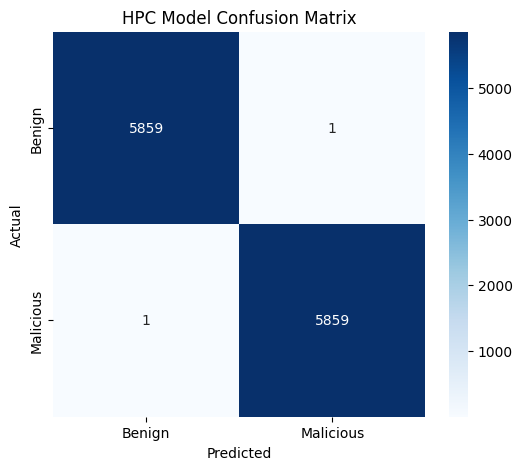

In [3]:
# === 1. Preprocess HPC Data ===
# Identify binary label column (object with two unique values) or assume 'Class'
if 'Class' in hpc_df.columns:
    label_col_hpc = 'Class'
elif 'Category' in hpc_df.columns:
    label_col_hpc = 'Category'
else:
    obj_cols = hpc_df.select_dtypes(include=['object']).columns.tolist()
    label_col_hpc = next(c for c in obj_cols if hpc_df[c].nunique()==2)
print(f"Using '{label_col_hpc}' as label for HPC data")

# Map label: assume benign/malicious mapping
y_hpc = hpc_df[label_col_hpc].map(lambda x: 0 if 'benign' in str(x).lower() else 1)
# Drop non-numeric cols
num_cols = hpc_df.select_dtypes(include=[np.number]).columns.tolist()
X_hpc = hpc_df[num_cols]

# Scale and reshape
scaler = StandardScaler()
Xh = scaler.fit_transform(X_hpc)
Xh_train, Xh_test, yh_train, yh_test = train_test_split(
    Xh, y_hpc, test_size=0.2, random_state=42, stratify=y_hpc)
Xh_train = Xh_train[:,:,np.newaxis]
Xh_test  = Xh_test[:,:,np.newaxis]

# PyTorch dataset & loader
class HPCDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values if hasattr(y,'values') else y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_h = HPCDataset(Xh_train, yh_train)
test_h  = HPCDataset(Xh_test, yh_test)
loader_h_train = DataLoader(train_h, batch_size=64, shuffle=True)
loader_h_test  = DataLoader(test_h, batch_size=64)

# 1D-CNN for HPC
class HPC1DCNN(nn.Module):
    def __init__(self, num_feat):
        super().__init__()
        self.conv1 = nn.Conv1d(1,16,3,padding=1)
        self.pool  = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16,32,3,padding=1)
        self.fc1   = nn.Linear((num_feat//4)*32,64)
        self.fc2   = nn.Linear(64,2)
    def forward(self,x):
        x = x.permute(0,2,1)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.flatten(1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

model_h = HPC1DCNN(Xh_train.shape[1])
opt_h = torch.optim.Adam(model_h.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

epochs = 10
for ep in range(epochs):
    model_h.train(); total_loss=0
    for Xb,yb in loader_h_train:
        opt_h.zero_grad()
        out = model_h(Xb)
        loss = crit(out, yb)
        loss.backward(); opt_h.step()
        total_loss += loss.item()
    print(f"HPC Epoch {ep+1}/{epochs}, Loss={total_loss/len(loader_h_train):.4f}")

# Evaluate HPC
model_h.eval(); preds_h, labs_h = [],[]
with torch.no_grad():
    for Xb,yb in loader_h_test:
        out = model_h(Xb)
        preds_h += out.argmax(1).tolist()
        labs_h  += yb.tolist()
# Print classification report and accuracy
print("HPC Classification Report:")
print(classification_report(labs_h, preds_h))
acc_h = accuracy_score(labs_h, preds_h)
print(f"HPC Test Accuracy: {acc_h:.4f}")

# Plot confusion matrix for HPC model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(labs_h, preds_h)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign','Malicious'], yticklabels=['Benign','Malicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('HPC Model Confusion Matrix')
plt.show()


In [6]:
# === 2. Preprocess Android Data ===
# Select object columns as candidate sequence features
obj_cols = android_df.select_dtypes(include=['object']).columns.tolist()
# There should be no 'label' among them if label is numeric; if so, filter it out safely
obj_cols = [c for c in obj_cols if c != 'label']
seq_col = max(obj_cols, key=lambda c: android_df[c].nunique())
print(f"Using '{seq_col}' as sequence column for Android data")

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len, vocab_size = 200, 5000
tok = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tok.fit_on_texts(android_df[seq_col].astype(str))
X_a = pad_sequences(tok.texts_to_sequences(android_df[seq_col].astype(str)), maxlen=max_len, padding='post')
y_a = android_df['label'].values

# Train/test split
X_a_train, X_a_test, y_a_train, y_a_test = train_test_split(
    X_a, y_a, test_size=0.2, random_state=42, stratify=y_a)

Using 'sha256' as sequence column for Android data


In [7]:
# === 2. Android Modeling on 'Package' ===
# Inspect available object columns
print("Android object columns:", android_df.select_dtypes(include=['object']).columns.tolist())
# Use 'Package' as text feature
texts = android_df['Package'].astype(str)
labels = android_df['label'].values

# 2.1 TF-IDF + XGBoost
tfidf_xgb = make_pipeline(
    TfidfVectorizer(max_features=5000, ngram_range=(1,2)),
    XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
)
X_txt_train, X_txt_test, y_txt_train, y_txt_test = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)
tfidf_xgb.fit(X_txt_train, y_txt_train)
print("TF-IDF+XGB Accuracy:", accuracy_score(y_txt_test, tfidf_xgb.predict(X_txt_test)))
print(classification_report(y_txt_test, tfidf_xgb.predict(X_txt_test)))

# 2.2 Deep Sequence Models on 'Package'
# Tokenize 'Package' strings
tok = tf.keras.preprocessing.text.Tokenizer(num_words=2000, oov_token='<OOV>')
tok.fit_on_texts(texts)
seqs = tok.texts_to_sequences(texts)
X_seq = tf.keras.preprocessing.sequence.pad_sequences(seqs, maxlen=50)
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, labels, test_size=0.2, stratify=labels, random_state=42
)

# LSTM with Attention
inputs = layers.Input(shape=(50,))
x = layers.Embedding(2000, 128)(inputs)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
att = layers.Dense(1, activation='tanh')(x); att = layers.Softmax(axis=1)(att)
x = layers.Dot(axes=1)([att, x]); x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
out = layers.Dense(1, activation='sigmoid')(x)
model_l = models.Model(inputs, out)
model_l.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model_l.fit(X_train, y_train, epochs=8, batch_size=128, validation_split=0.1)
print("LSTM Att Accuracy:", model_l.evaluate(X_test, y_test)[1])

# Transformer Encoder using MultiHeadAttention and Feed-Forward
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout
# Build a simple Transformer block
inputs_t = layers.Input(shape=(50,))
t = layers.Embedding(2000, 128)(inputs_t)
# Self-attention layer
attn_output = MultiHeadAttention(num_heads=4, key_dim=64)(t, t)
attn_output = Dropout(0.1)(attn_output)
out1 = LayerNormalization(epsilon=1e-6)(t + attn_output)
# Feed-forward network
ffn = layers.Dense(256, activation='relu')(out1)
ffn = layers.Dense(128)(ffn)
ffn_output = Dropout(0.1)(ffn)
out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
# Pooling and classification
x_tr = layers.GlobalAveragePooling1D()(out2)
x_tr = layers.Dense(64, activation='relu')(x_tr)
out_tr = layers.Dense(1, activation='sigmoid')(x_tr)
model_t = models.Model(inputs_t, out_tr)
model_t.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model_t.fit(X_train, y_train, epochs=6, batch_size=64, validation_split=0.1)
print("Transformer Accuracy:", model_t.evaluate(X_test, y_test)[1])

# 2.3 Ensemble of TF-IDF+XGB, LSTM, and Transformer
l_probs = model_l.predict(X_test).flatten()
t_probs = model_t.predict(X_test).flatten()
x_probs = tfidf_xgb.predict_proba(X_txt_test)[:,1]
ensemble = (l_probs + t_probs + x_probs) / 3
en_pred = (ensemble > 0.5).astype(int)
print("Ensemble Accuracy:", accuracy_score(y_test, en_pred))
print(classification_report(y_test, en_pred))

# Next: Cross-Platform Contrastive & Fusion
l_probs = model_l.predict(X_test).flatten()
t_probs = model_t.predict(X_test).flatten()
x_probs = tfidf_xgb.predict_proba(X_txt_test)[:,1]
ensemble = (l_probs + t_probs + x_probs) / 3
en_pred = (ensemble > 0.5).astype(int)
print("Ensemble Accuracy:", accuracy_score(y_test, en_pred))
print(classification_report(y_test, en_pred))

Android object columns: ['Package', 'sha256', 'FirstModDate', 'LastModDate', 'MalFamily', 'EarliestModDate', 'HighestModDate']


c:\Users\anvit\Desktop\SEM_5\ML\ML Project\ML Code\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:48:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


TF-IDF+XGB Accuracy: 0.6874692183212552
              precision    recall  f1-score   support

           0       0.65      0.84      0.73     14400
           1       0.76      0.54      0.63     14026

    accuracy                           0.69     28426
   macro avg       0.70      0.69      0.68     28426
weighted avg       0.70      0.69      0.68     28426

Epoch 1/8
800/800 ━━━━━━━━━━━━━━━━━━━━ 64s 77ms/step - accuracy: 0.7222 - loss: 0.4815 - val_accuracy: 0.7713 - val_loss: 0.4065
Epoch 2/8
800/800 ━━━━━━━━━━━━━━━━━━━━ 72s 90ms/step - accuracy: 0.7743 - loss: 0.3917 - val_accuracy: 0.7836 - val_loss: 0.3886
Epoch 3/8
800/800 ━━━━━━━━━━━━━━━━━━━━ 86s 108ms/step - accuracy: 0.7845 - loss: 0.3760 - val_accuracy: 0.7800 - val_loss: 0.3846
Epoch 4/8
800/800 ━━━━━━━━━━━━━━━━━━━━ 89s 112ms/step - accuracy: 0.7869 - loss: 0.3679 - val_accuracy: 0.7829 - val_loss: 0.3877
Epoch 5/8
800/800 ━━━━━━━━━━━━━━━━━━━━ 93s 116ms/step - accuracy: 0.7905 - loss: 0.3612 - val_accuracy: 0.7881 - va